<a href="https://colab.research.google.com/github/yepedraza/nextword-predict/blob/master/nxtWordPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Google Drive connection**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Libraries import**

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import string

### **Data Preprocessing**

I read the text using the utf8 encoding and create the variable where I am going to store the lines of text


In [3]:
dfPath = '/content/drive/MyDrive/Personal projects/nextword-prediction/metamorphosis_clean.txt'
dataText = open(dfPath, "r", encoding = "utf8")
lines = []

I add each line of text to the list

In [4]:
for i in dataText:
    lines.append(i)

I [join](https://www.w3schools.com/python/ref_string_join.asp) the lines of text and remove related elements to the unnecessary lines of text




In [5]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')

I make sure I don't have repeated words

In [6]:
no_rep = []

for i in data.split():
    if i not in no_rep:
        no_rep.append(i)
        
data = ' '.join(no_rep)

### **Tokenization**

I use [Tokenizer](https://keras.io/api/preprocessing/text/) to vectorize the text and then transform it into a sequence of numbers

*Note: I save the tokenizer for the prediction script*

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]

I find the size of the *word index* to later use it as a criterion to convert the output data into categorical variables

In [8]:
v_size = len(tokenizer.word_index) + 1

I create the data sequences to later use them for the input and output data

In [9]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
sequences = np.array(sequences)

I create the input and output data of the model with the text sequences

In [10]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

I convert the output data to categorical variables

In [11]:
y = to_categorical(y, num_classes=v_size)

### **Model creation**

In [12]:
model = Sequential()
model.add(Embedding(v_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(v_size, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             26170     
                                                                 
 lstm (LSTM)                 (None, 1, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 2617)              2619617   
                                                                 
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


I create the callbacks to save the model as there is an improvement in the performance of the loss function, in addition to reducing the learning factor of the optimizer.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpoint = ModelCheckpoint("nxtword.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

In [16]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

In [19]:
history = model.fit(X, 
          y, 
          epochs=150, 
          batch_size=64, 
          callbacks=[checkpoint, reduce]
          ).history

Epoch 1/150
60/61 [============================>.] - ETA: 0s - loss: 0.6325 - accuracy: 0.5755
Epoch 1: loss did not improve from 0.63145
61/61 [==============================] - 1s 12ms/step - loss: 0.6330 - accuracy: 0.5737 - lr: 1.0000e-04
Epoch 2/150
60/61 [============================>.] - ETA: 0s - loss: 0.6290 - accuracy: 0.5763
Epoch 2: loss did not improve from 0.63145
61/61 [==============================] - 1s 11ms/step - loss: 0.6316 - accuracy: 0.5744 - lr: 1.0000e-04
Epoch 3/150
60/61 [============================>.] - ETA: 0s - loss: 0.6338 - accuracy: 0.5721
Epoch 3: loss did not improve from 0.63145
61/61 [==============================] - 1s 11ms/step - loss: 0.6318 - accuracy: 0.5732 - lr: 1.0000e-04
Epoch 4/150
61/61 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.5834
Epoch 4: loss improved from 0.63145 to 0.62981, saving model to nxtword.h5
61/61 [==============================] - 1s 19ms/step - loss: 0.6298 - accuracy: 0.5834 - lr: 1.0000e

### **Model Analysis**

In [20]:
pickle.dump(history, open("history.p", "wb"))
history = pickle.load(open("history.p", "rb"))

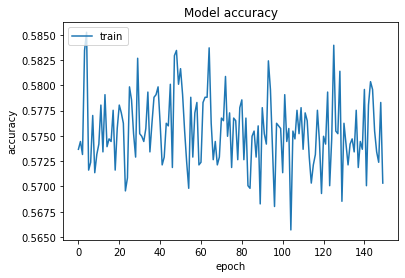

In [28]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

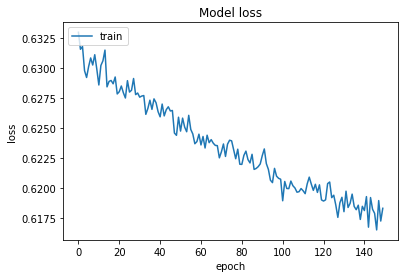

In [29]:
plt.plot(history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')